#  Sentence Classification using PubMed 200k RCT dataset (BERT withTPU)

In [ ]:
#### %tensorflow_version 2.x   
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0


##  google Colab TPU set up

In [ ]:
import os

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.45.37.162:8470']


REPLICAS:  8


## Preprocessing Data


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

In [ ]:
## you need the following if you run your code in google colab
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
def preprocessing_data(file):
    
    import pandas as pd
    import re


    df = pd.read_csv(file, delimiter = "\t",names=["y", "X"])

    df=df.dropna()

    df=df.reset_index(drop=True)

    def clean_text(doc):

        document = remove_tags(doc)

        document = re.sub('[^a-zA-Z]', ' ', document)

        document = re.sub(r"\s+[a-zA-Z]\s+", ' ', document)

        document = re.sub(r'\s+', ' ', document)

        return document

    TAG_RE = re.compile(r'<[^>]+>')

    def remove_tags(document):
        return TAG_RE.sub('', document)

 

    df['X']=df['X'].apply(clean_text)
    df['y']=df['y'].map({'OBJECTIVE':0, 'METHODS':1, 'RESULTS':2, 'CONCLUSIONS':3, 'BACKGROUND':4})



    return df



In [ ]:
train_df =preprocessing_data('<file path of "train.txt" dataset>')

In [ ]:
train_df.shape

(2211861, 2)

In [ ]:
train_df.head()

,y,X
0,4,The emergence of HIV as chronic condition mean...
1,4,This paper describes the design and evaluation...
2,1,This study is designed as randomised controlle...
3,1,The intervention group will participate in the...
4,1,The program is based on self efficacy theory a...


In [ ]:
dev_df =preprocessing_data('<file path of "dev.txt" dataset>')

In [ ]:
dev_df.shape[0]

28932

In [ ]:
dev_df.head()

,y,X
0,4,Adrenergic activation is thought to be an impo...
1,2,Systemic venous norepinephrine was measured at...
2,2,Baseline norepinephrine level was associated w...
3,2,On multivariate analysis baseline norepinephri...
4,2,In contrast the relation of the change in nore...


In [ ]:
test_df =preprocessing_data('<file path of "test.txt" dataset>')

In [ ]:
test_df.shape

(29493, 2)

In [ ]:
test_df.head()

,y,X
0,4,Many pathogenic processes and diseases are the...
1,4,It was recently demonstrated that supraphysiol...
2,4,In the present study we examined the associati...
3,4,In addition we compared plasma levels of MAp M...
4,1,A total of MI patients and control persons wer...


In [ ]:
def count_word(text):
    res = len(text.split())
    return res
    
    
     
    
    
     

In [ ]:
train_df['WordCount']=train_df['X'].apply(count_word)

In [ ]:
train_df.head()

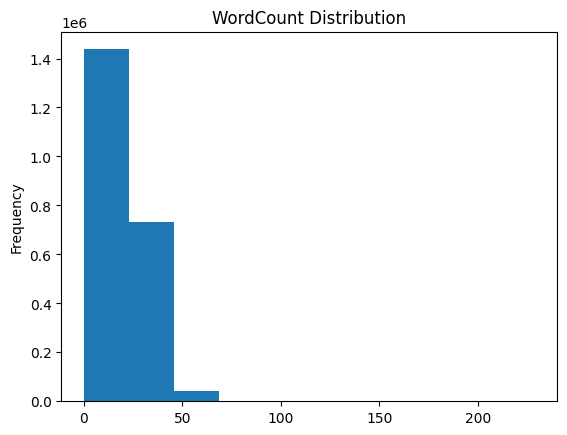

In [ ]:
train_df.WordCount.plot(kind='hist', title='WordCount Distribution');

## Target (y) distribution of the first 300,000 sentences in the Training dataset

<Axes: ylabel='y'>

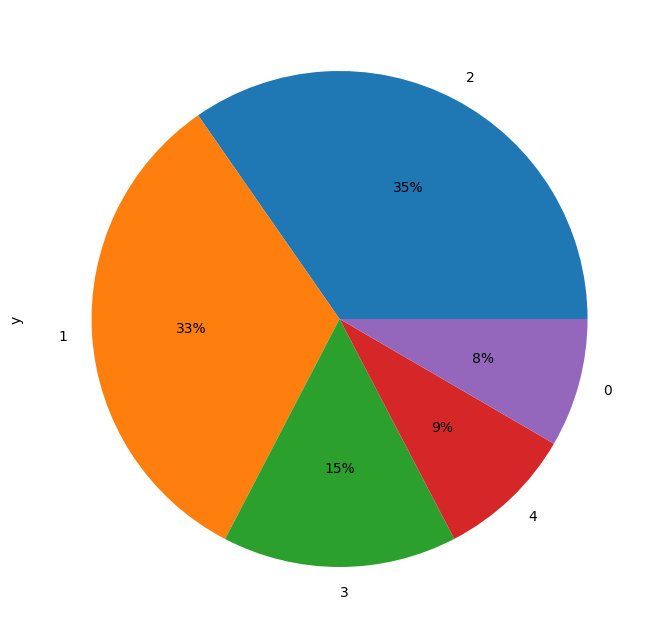

In [ ]:
plt.rcParams["figure.figsize"] = [8,10] 
train_df[0:300000].y.value_counts().plot(kind='pie', autopct='%1.0f%%')

## Target (y) distribution in the Development dataset

<Axes: ylabel='y'>

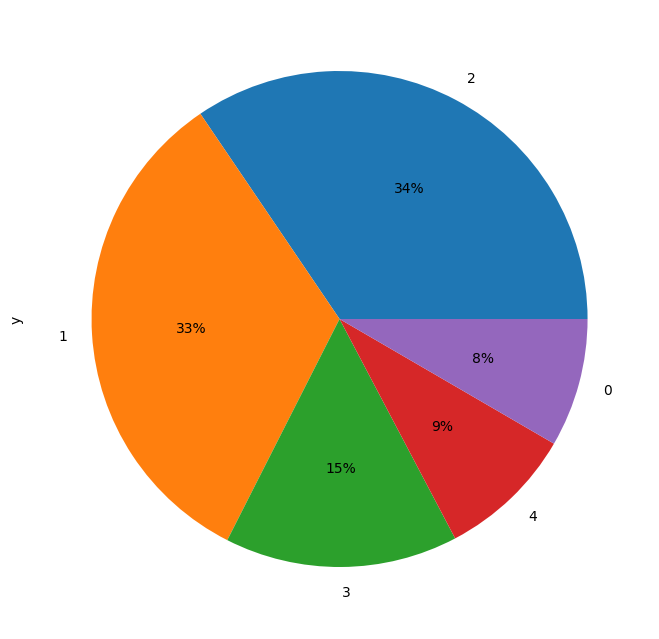

In [ ]:
plt.rcParams["figure.figsize"] = [8,10] 
dev_df.y.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
#print("Hub version: ", hub.__version__)
#print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True


## Install transformers package

In [ ]:
!pip install transformers

## Import BertTokenizer, BertConfig and TFBertForSequenceClassification from transformers

In [ ]:
from transformers import BertConfig 
from transformers import (TFBertForSequenceClassification, 
                          BertTokenizer) 
from tqdm import tqdm



## training, validation(development) and test dataset

In [ ]:
X_train = train_df['X'].values
X_val = dev_df['X'].values
X_test = test_df['X'].values

y_train = train_df['y'].values
y_val = dev_df['y'].values
y_test = test_df['y'].values


print("Shape of training data: {0}, \nShape of test data: {1} \nShape of val data: {2}".format(X_train.shape, X_test.shape, X_val.shape))


Shape of training data: (2211861,), 
Shape of test data: (29493,) 
Shape of val data: (28932,)


## Create an object of the BertTokenizer class

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

## Convert texts to BERT input format

In [ ]:
max_length= 100
def text_to_bert_input(reviews):
    input_ids,attention_masks,token_type_ids=[],[],[]
    
    for review in tqdm(reviews, position=0, leave=True):
        #print(review)
        bert_inputs = bert_tokenizer(review,add_special_tokens=True,padding='max_length',
                                     max_length=max_length, truncation = True)
    
        input, mask, token_type = bert_inputs["input_ids"], bert_inputs["attention_mask"], bert_inputs["token_type_ids"]
        
        input_ids.append(input)
        attention_masks.append(mask)
        token_type_ids.append(token_type)

    
    
    return [np.asarray(input_ids), 
            np.asarray(attention_masks), 
            np.asarray(token_type_ids)]

In [ ]:
X_val.shape[0]

28932

In [ ]:
X_train.shape[0]

2211861

In [ ]:
# val_sample_size= X_val.shape[0]
# X_val[0:val_sample_size].shape

In [ ]:
## taking 300K samples of training dataset
## taking all samples of validation and test dataset

train_sample_size= 300000
val_sample_size= X_val.shape[0]

X_train_input=text_to_bert_input(X_train[0:train_sample_size])
X_val_input=text_to_bert_input(X_val[0:val_sample_size])
X_test_input=text_to_bert_input(X_test)



100%|██████████| 29493/29493 [00:23<00:00, 1261.51it/s]


##  Convert the input data into tensors

In [ ]:
def convert_to_tensors(input_ids,attention_masks,token_type_ids,y):
    
    
    return {"input_ids": input_ids,
          "attention_mask": attention_masks,
          "token_type_ids": token_type_ids},y



In [ ]:
## taking 300K samples of training dataset
## taking all samples of validation and test dataset


train_dataset = tf.data.Dataset.from_tensor_slices((X_train_input[0],X_train_input[1],X_train_input[2],y_train[0:train_sample_size])).map(convert_to_tensors).shuffle(100).batch(1024) 
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input[0],X_test_input[1],X_test_input[2],y_test)).map(convert_to_tensors).batch(1024)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_input[0],X_val_input[1],X_val_input[2],y_val[0:val_sample_size])).map(convert_to_tensors).batch(1024)


## taking whole samples y_train
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_input[0],X_train_input[1],X_train_input[2],y_train)).map(convert_to_tensors).shuffle(100).batch(32) 
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input[0],X_test_input[1],X_test_input[2],y_test)).map(convert_to_tensors).batch(32)
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val_input[0],X_val_input[1],X_val_input[2],y_val)).map(convert_to_tensors).batch(32)

## Fine-Tune BERT for Sequencial Sentence Classfication

In [ ]:
## Load pretrained Model

num_labels = 5 
config = BertConfig.from_pretrained("bert-base-cased", num_labels=num_labels)

def create_model(num_labels, config):
    model = TFBertForSequenceClassification.from_pretrained('bert-base-cased', config=config)
    return model
    
      

In [ ]:
## define Optimizer, Loss-function and Evaluation metric of the Model

with strategy.scope():
    model = create_model(num_labels, config)
    opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=opt, loss=loss, metrics=[metric])
  
    
      


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
## Required to save models in HDF5 format

!pip install pyyaml h5py  


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### Training model and saving the weights of the Best model

import time
start_time = time.time()

filepath ='<provide the file path to save best Model Weights>'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= filepath, 
                                                         save_weights_only=True, save_best_only=True,verbose=1)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks= [checkpoint_callback])

print("--- %s seconds ---" % (time.time() - start_time))

## Evaluate Model Performance on Test Dataset

#### Evaluate model performance on the test dataset from the last epoch (epoch # 10)

In [ ]:
import time
start_time = time.time()

model.evaluate(test_dataset)

print("--- %s seconds ---" % (time.time() - start_time))

29/29 [==============================] - 7s 191ms/step - loss: 0.5624 - accuracy: 0.8465
--- 7.032700538635254 seconds ---


####  Evaluate model performance on the test dataset using the best saved model's weights

In [ ]:
### Load the saved weights (BEST Model)
model.load_weights('<file path of the saved best Model Weights>')


In [ ]:
import time
start_time = time.time()

model.evaluate(test_dataset)

print("--- %s seconds ---" % (time.time() - start_time))

29/29 [==============================] - 7s 190ms/step - loss: 0.3725 - accuracy: 0.8669
--- 7.147668838500977 seconds ---


#### Model predictions on Test dataset

In [ ]:
import time
start_time = time.time()

predictions = model.predict(test_dataset)

print("--- %s seconds ---" % (time.time() - start_time))


29/29 [==============================] - 10s 192ms/step
--- 10.44615626335144 seconds ---


In [ ]:
predictions

TFSequenceClassifierOutput(loss=None, logits=array([[ 2.5482628 , -2.7450137 , -2.9546306 , -0.41957343,  3.6694033 ],
       [ 3.3378258 , -1.8579726 , -3.2704957 , -2.0860353 ,  3.7770917 ],
       [ 3.4703803 , -0.97279036, -3.2290156 , -2.9873388 ,  3.2496512 ],
       ...,
       [-3.2125213 ,  0.01970381,  5.757324  , -0.03359951, -3.312443  ],
       [ 1.1155425 , -3.5328887 , -2.5271087 ,  3.6652343 ,  1.7963988 ],
       [-2.042558  , -2.5404603 ,  2.703283  ,  3.7015834 , -1.707179  ]],
      dtype=float32), hidden_states=None, attentions=None)

In [ ]:
y_pred = np.argmax(predictions.logits, axis=1)

In [12]:
y_test

array([4, 4, 4, ..., 2, 3, 3])

In [11]:
y_pred

array([4, 4, 0, ..., 2, 3, 3])

### Classification Report

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[1536  159    8   83  591]
 [  79 9193  393   49   37]
 [   8  504 9411  320   33]
 [   5   47  574 3596  204]
 [ 414  150   21  246 1832]]
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      2377
           1       0.91      0.94      0.93      9751
           2       0.90      0.92      0.91     10276
           3       0.84      0.81      0.82      4426
           4       0.68      0.69      0.68      2663

    accuracy                           0.87     29493
   macro avg       0.82      0.80      0.81     29493
weighted avg       0.87      0.87      0.87     29493

0.8669175736615468


### Confusion Matrix Heat Map

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
  # 'OBJECTIVE':0, 'METHODS':1, 'RESULTS':2, 'CONCLUSIONS':3, 'BACKGROUND':4

In [15]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

In [16]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['OBJECTIVE','METHODS','RESULTS','CONCLUSIONS','BACKGROUND'], 
                     columns = ['OBJECTIVE','METHODS','RESULTS','CONCLUSIONS','BACKGROUND'])

In [18]:
cm_df

,OBJECTIVE,METHODS,RESULTS,CONCLUSIONS,BACKGROUND
OBJECTIVE,1536,159,8,83,591
METHODS,79,9193,393,49,37
RESULTS,8,504,9411,320,33
CONCLUSIONS,5,47,574,3596,204
BACKGROUND,414,150,21,246,1832


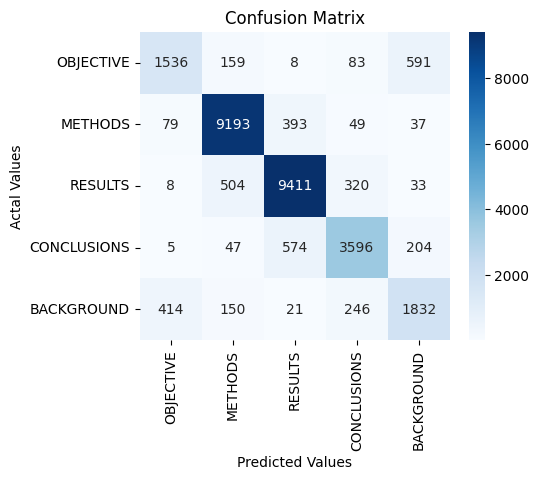

In [21]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True,cmap='Blues',fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()